In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv(r"C:\Users\User\Documents\MY WORK 2024\TP2\Spaza-Dataset.csv")

# Display the first few rows of the dataset
print(df.head())

         Date      Product  Sales (Units)  Revenue (ZAR)  Inventory Levels  \
0  2023-01-02   Maize Meal             25         875.50                35   
1  2023-01-05  Cooking Oil             15         600.75                60   
2  2023-01-07        Sugar             10         300.30                50   
3  2023-01-12        Bread             20         200.00                40   
4  2023-01-15         Milk             30         450.00                30   

     Event Impact  Season  
0  Local Festival  Summer  
1  Public Holiday  Summer  
2             NaN  Summer  
3             NaN  Summer  
4             NaN  Autumn  


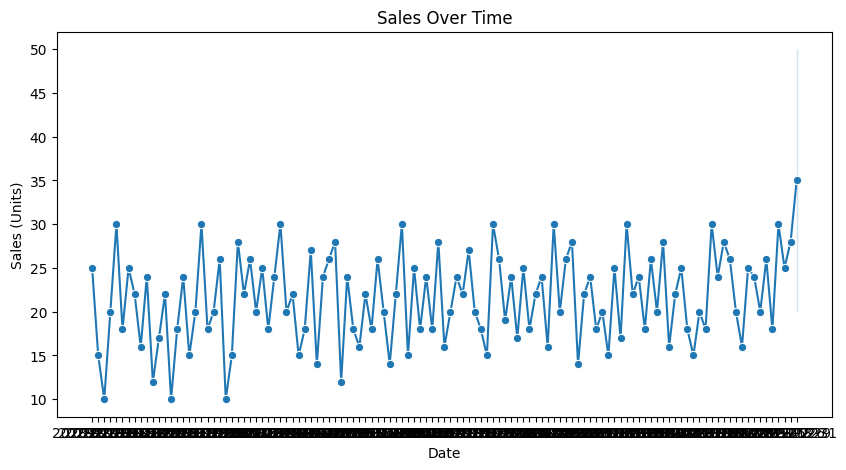

In [6]:
# Fill missing 'Event Impact' with 'No Event' since it is a categorical variable
df['Event Impact'].fillna('No Event', inplace=True)

# Plot Sales over time to check trends
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Date', y='Sales (Units)', marker='o')
plt.title('Sales Over Time')
plt.show()

# Encoding 'Season' and 'Event Impact' for modeling
df = pd.get_dummies(df, columns=['Season', 'Event Impact'], drop_first=True)


In [11]:
#Implementing Prophet

from prophet import Prophet #Prophet for the trend and seasonaly modeling
import warnings     # Suppress FutureWarning messages to prevent them from cluttering the output.
                    # This is useful when the warnings don't affect the current functionality
                    # but may relate to changes in future versions of libraries like pandas.
warnings.filterwarnings("ignore", category=FutureWarning)


22:40:22 - cmdstanpy - INFO - Chain [1] start processing
22:40:23 - cmdstanpy - INFO - Chain [1] done processing


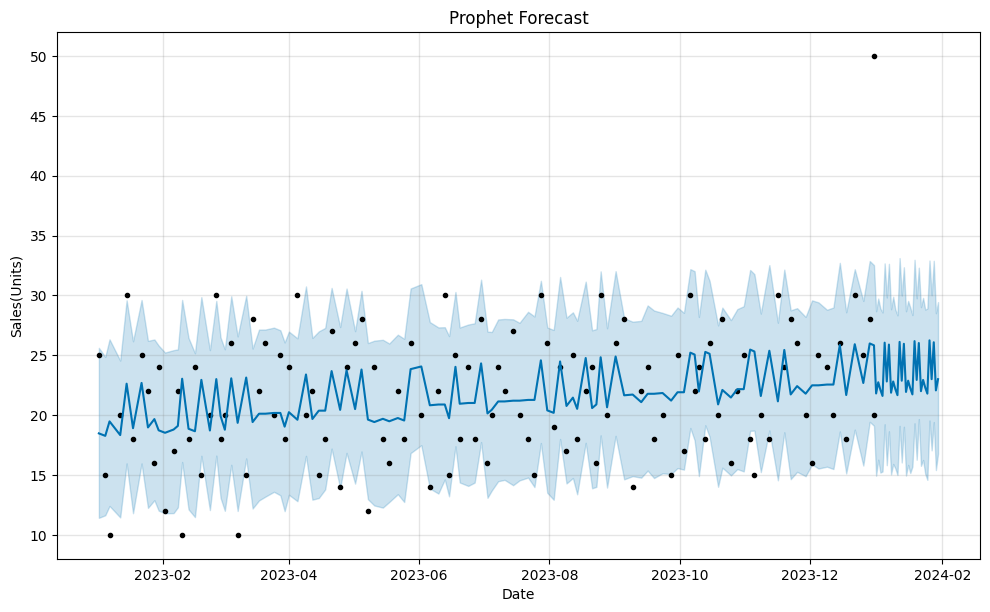

In [22]:


# Prophet requires a specific format for the dataset
prophet_data = df[['Date', 'Sales (Units)']].rename(columns={'Date': 'ds', 'Sales (Units)': 'y'})

# Initialize and fit Prophet model
model_prophet = Prophet()
model_prophet.fit(prophet_data)

# Create future dataframe for predictions
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

# Plot forecast
model_prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales(Units)')
plt.show()


In [19]:
# Implementing ARIMA
from statsmodels.tsa.arima.model import ARIMA  # ARIMA for traditional time series forecasting

ADF Statistic: -11.69797982343761
p-value: 1.5937302143229167e-21


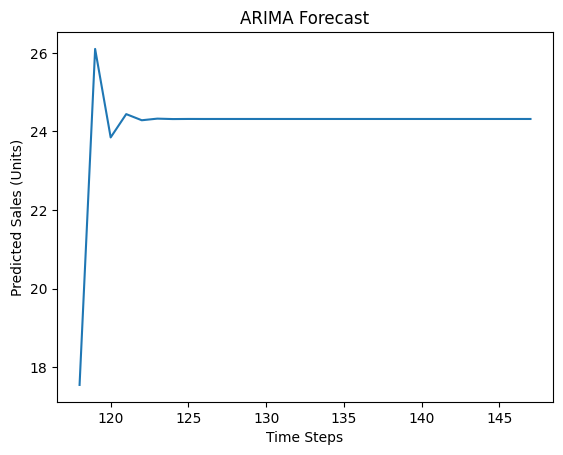

In [23]:
# ARIMA requires the data to be stationary, we check and make it stationary if needed
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

test_stationarity(df['Sales (Units)'])

# Differencing the data if non-stationary
df['Sales Diff'] = df['Sales (Units)'].diff().dropna()

# Fit ARIMA model
arima_model = ARIMA(df['Sales (Units)'], order=(1,1,1))
arima_model_fit = arima_model.fit()

# Make predictions
arima_forecast = arima_model_fit.forecast(steps=30)
plt.plot(arima_forecast)
plt.xlabel('Time Steps')
plt.ylabel('Predicted Sales (Units)')
plt.title('ARIMA Forecast')
plt.show()


In [32]:
#Implement LSTM
import torch  # PyTorch library for deep learning and neural networks
import torch.nn as nn  # Neural network modules and classes
import numpy as np  # Numerical operations, particularly for arrays
import pandas as pd  # Data manipulation and analysis
from sklearn.preprocessing import MinMaxScaler  # Scaling data to a range
import matplotlib.pyplot as plt  # Plotting and visualization


Epoch [1/1], Loss: 0.21659418940544128


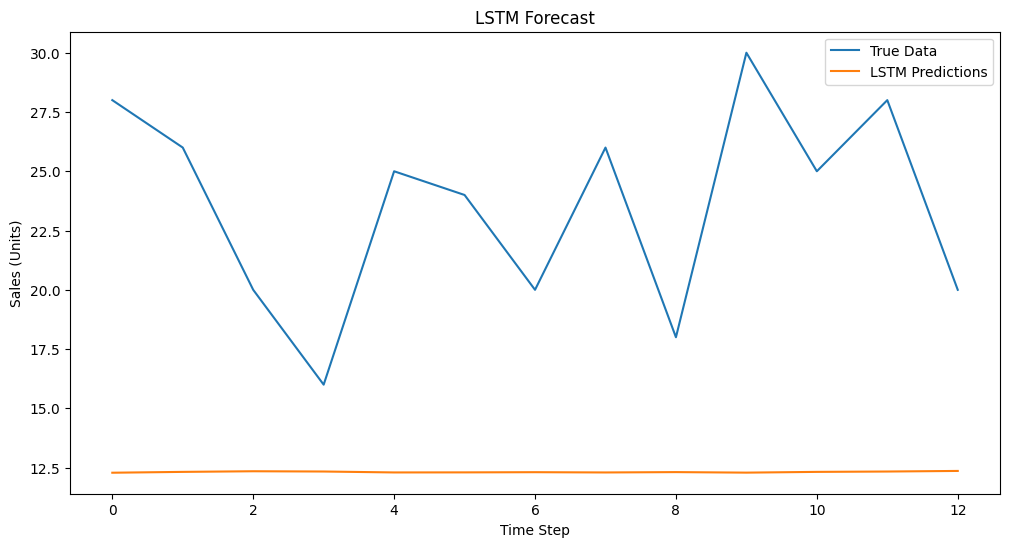

In [35]:
# Scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Sales (Units)']])

# Split into training and test data
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create dataset in LSTM format
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Define LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize model, loss function, and optimizer
input_size = 1
hidden_size = 50
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.to(device))
    loss = criterion(outputs.squeeze(), Y_train.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test.to(device))
    predictions = predictions.cpu().numpy()

# Inverse transform to original scale
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plot LSTM forecast
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='True Data')
plt.plot(predictions, label='LSTM Predictions')
plt.title('LSTM Forecast')
plt.xlabel('Time Step')  # Label for x-axis
plt.ylabel('Sales (Units)')  # Label for y-axis
plt.legend()
plt.show()